Desafio Cientista de Dados: Análise Cinematográfica - Indicium


O objetivo desse projeto é treinar um modelo de Machine Learning para ler e interpretar dados de filmes para definir qual o proximo filme a ser lançado.

## **Criação do ambiente de desenvolvimento:**
 Criar um ambiente de desenvolvimento (VENV) e importar as bibliotecas necessarias para a execução do projeto.

In [134]:
# pip install -r requirements.txt (rodar uma vez para instalar as bibliotecas)

# criar o ambiente virtual (rodar uma vez)
# python -m venv venv

# ativar o ambiente virtual (rodar sempre que for iniciar o projeto)
# Windows: .\venv\Scripts\activate
# Mac/Linux: source venv/bin/activate

##=======================================##

# Importando as bibliotecas necessarias

# %pip install nltk #(rodar uma vez para instalar o nltk)

import pandas as pd # Manipulação de dados
import numpy as np # Calculos Numéricos
import matplotlib.pyplot as plt # # Visualização de dados
import seaborn as sns # Visualização de dados
import nltk # Processamento de linguagem natural
import joblib # Salvamento de modelos
import re # Expressões regulares

# Bibliotecas para Machine Learning
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score, hamming_loss, r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# nltk.download('stopwords')# (rodar uma vez para baixar as stopwords)
# nltk.download('punkt') # (rodar uma vez para baixar o tokenizer)
# nltk.download('wordnet') # (rodar uma vez para baixar o lemmatizer)
# nltk.download('punkt_tab')(rodar uma vez para baixar o tokenizer)





## **Análise Exploratória dos dados (EDA)**
 Análise Exploratória dos dados (EDA) -> O objetivo neste passo é descobrir padrões, identificar anomalias, testar hipóteses e verificar suposições com ajuda das estatisticas e representações gráficas.

Nesse passo eu faço uma análise exploratória incial dos dados. Passo fundamental para saber a saúde dos dados, antes de começar a trabalhar nele

In [135]:
display = pd.read_csv('../data/desafio_indicium_imdb.csv')

display.head() # Visualizando as 5 primeiras linhas do dataset
display.info() # Informações gerais do dataset
display.describe() # Estatisticas descritivas
display.isnull().sum() # Verificando valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

>Insights iniciais:

    1- O dataset possui 16 colunas
    2- Coluna unnamed é um indice desnecessario, irei remove-la para evitar poluição
    3- As colunas Released_Year, Runtime e Gross são do tipo object, quando na verdade deveriam ser do tipo numérico.
    4- As colunas Certificate, Meta_score e Gross possuem alguns valores não nulos faltando, isso significa que temos um problema de dados ausentes.
    

##### 2. Limpeza e normalização

In [136]:

display = display.drop('Unnamed: 0', axis=1, errors='ignore') # Removendo a coluna 'Unnamed: 0' se existir
print("\nColunas após a limpeza:", display.columns)



Colunas após a limpeza: Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')


  Agora eu irei padronizar as colunas que deveriam ser do tipo numérico, esse passo é fundamental para a criação do modelo que vem no passo à seguir.

In [137]:
# Primeiro eu vou dar um print nas 5 primeiras linhas da coluna GROSS para entender como ela esta formatada

print(display['Gross'].head())


0    134,966,411
1    534,858,444
2     57,300,000
3      4,360,000
4    377,845,905
Name: Gross, dtype: object


- Após a verificação dos dados ja noto que precisarei apenas remover as virgulas e converter a coluna para float


In [138]:
# Limpando a coluna Gross
display['Gross'] = display['Gross'].str.replace('$', '').str.replace('M', '').str.replace(',', '').astype(float)

# Verificando se a limpeza foi bem sucedida
print(display['Gross'].head())

0    134966411.0
1    534858444.0
2     57300000.0
3      4360000.0
4    377845905.0
Name: Gross, dtype: float64


- Farei a mesma coisa para Runtime

In [139]:
display['Runtime'] = display['Runtime'].str.replace(' min', '').astype(float)


 - Ao converter Released_Year para Float, encontrei o seguinte erro: "Algumas linhas possuem o caracter PG, o que torna impossivel de converter para float". A solução que encontrei para esse problema é:
    -> Encontrar as linhas
    -> Identificar o porque "PG" aparece em Released_Year

In [140]:
temp = pd.to_numeric(display['Released_Year'], errors='coerce')

# Encontrar as linhas onde a conversão falhou

linhas_com_erro = display[temp.isnull()]

print("Linhas com erro na conversão de 'Released_Year':")

# Dou um print nas linhas adjacentes a Released_Year para tentar entender o que esta acontecendo
print(linhas_com_erro[['Series_Title', 'Released_Year', 'Certificate']])

# Verifico que os dados estão alterados, ou seja, algum erro de digitação ou formatação ocorreu.
# A linha 965 possui "PG" em Released_Year, o que é incorreto


Linhas com erro na conversão de 'Released_Year':
    Series_Title Released_Year Certificate
965    Apollo 13            PG           U


- Utilizo a função .loc do Pandas para fazer a conversão da linha 965, essa função nos permite acessar os dados de um DataFrame com base nos rótulos (linhas e colunas). E atribúo o ano 1995


In [141]:
display.loc[965, 'Released_Year'] = 1995
display.loc[965, 'Certificate'] = 'U'

In [142]:
print("Linha 965 após a correção:")
print(display.loc[965, ['Released_Year', 'Certificate']])

Linha 965 após a correção:
Released_Year    1995
Certificate         U
Name: 965, dtype: object


- Por fim converto para int64

In [143]:
display['Released_Year'] = pd.to_numeric(display['Released_Year'], errors="coerce")

print(display['Released_Year'].head())

0    1972
1    2008
2    1974
3    1957
4    2003
Name: Released_Year, dtype: int64


> ### Preenchimento de valores nulos:

Agora com os dados padronizados podemos seguir para o proximo passo, que será a criação do modelo que ira preencher os dados nulos no DataFrame.

Indetifiquei diversas linhas de dados ausentes (cerca de 427 linhas). Eu optei por desenvolver um modelo de machine learning para imputar esses dados, ao inves de simplesmente apaga-los ou simular uma média.

Essa decisão foi tomada devido à grande quantidade de dados ausentes. E essa me parece a melhor escolha pelos seguintes motivos:

    - Preservação dos dados
    - Mantém a variabilidade
    - Melhora na qualidade dos dados
    - Redução do viés

> Na célula abaixo será criado o modelo

In [144]:

def preencher_dados_numericos(display, coluna_ausente, colunas_previsoras, modelo=LinearRegression()):
    '''
    Essa função é responsável por preencher valores ausente em uma coluna nmérica usando um modelo de regressão

    Argumentos:
        display: DataFrame do Pandas contendo os dados
        coluna_ausente: Nome da coluna que possui valores ausentes
        colunas_previsoras: lista de colunas que serão usadas como variáveis independentes para prever os valores ausentes

    Retornos:
        DataFrame com os valores preenchidos.
    '''

    # 1. Copiar o dataframe original para evitar modificar os dados originais

    dados_copia = display.copy()

    # 2. Separar os dados em dois conjuntos: um com valores ausentes e outro sem valores ausentes
    # as linhas com os dados completos serão utilizadas para treinar o modelo de regressão
    dados_treino = dados_copia.dropna(subset=[coluna_ausente])

    # linhas com os dados ausentes que serão preenchidas
    dados_prever = dados_copia[dados_copia[coluna_ausente].isnull()]
    
    # 3.Preparar variaveis de entrada e saída

    A_treino = dados_treino[colunas_previsoras]
    B_treino = dados_treino[coluna_ausente]
    A_prever = dados_prever[colunas_previsoras]

    # 4. Treinar o modelo de regressão
    # Esse modelo seria treinado para aprender a relação entre as colunas complestas e as faltantes

    modelo.fit(A_treino, B_treino)

    # 5. Fazer previsões para os valores ausentes
    valores_previstos = modelo.predict(A_prever)

    # Arredondar os valores previstos para o inteiro mais próximo
    valores_previstos = np.round(valores_previstos)

    # 6. Substituir os valores ausentes pelos valores previstos
    # Utilizo o .loc para garantir que os valores sejam atributidos corretamente nos indices

    dados_copia.loc[dados_copia[coluna_ausente].isnull(), coluna_ausente] = valores_previstos

    # print(f"Valores ausentes na coluna '{coluna_ausente}' foram preenchidos com sucesso usando {modelo.__class__.__name__}.")

    return dados_copia

''' Criando a previsão para Certificate, como a coluna é categórica um modelo de regressão 
    não vai funcionar justamente por não serem valores numéricos, então optei por preencher
    usando a moda (valor mais frequente), isso vai garantir uma imputação rapida e eficaz, 
'''

def preencher_dados_categoricos(display, coluna_ausente):
    '''
    Essa função é responsável por preencher valores ausente em uma coluna categórica usando a moda (valor mais frequente)

    Argumentos:
        display: DataFrame do Pandas contendo os dados
        coluna_ausente: Nome da coluna que possui valores ausentes

    Retornos:
        DataFrame com os valores preenchidos.
    '''

    # 1. Copiar o dataframe original para evitar modificar os dados originais

    dados_copia = display.copy()

    # 2. Calcular a moda (valor mais frequente) da coluna categórica
    moda = dados_copia[coluna_ausente].mode()[0]

    # 3. Preencher os valores ausentes com a moda
    dados_copia[coluna_ausente] = dados_copia[coluna_ausente].fillna(moda)

    # print(f"Valores ausentes na coluna '{coluna_ausente}' foram preenchidos com sucesso usando a moda: {moda}.")

    return dados_copia

- após a criação do modelo devemos imputar as colunas:

#### Gross
    Utilizando a função de preencher dados numericos do modelo

In [145]:
display = preencher_dados_numericos(
    display=display,
    coluna_ausente='Gross',
    colunas_previsoras=['IMDB_Rating', 'Runtime']
)

#### Meta_score
    Utilizando a função de preencher dados numericos do modelo

In [146]:
display = preencher_dados_numericos(
    display=display,
    coluna_ausente='Meta_score',
    colunas_previsoras=['IMDB_Rating', 'Runtime', 'Gross']
)

#### Certificate
    Utilizando a função de preencher dados categóricos do modelo

In [147]:
display = preencher_dados_categoricos(
    display=display,
    coluna_ausente='Certificate'
)

### **Após toda a normalização eu irei adicionar os códigos em uma única função só para chamar quando for criar os modelos**

In [148]:
def normalizar(display):
    
    display['Gross'] = display['Gross'].str.replace('$', '').str.replace('M', '').str.replace(',', '').astype(float)
    display['Runtime'] = display['Runtime'].str.replace(' min', '').astype(float)
    
    display = preencher_dados_numericos(
    display=display,
    coluna_ausente='Gross',
    colunas_previsoras=['IMDB_Rating', 'Runtime']
    )
    
    display = preencher_dados_numericos(
    display=display,
    coluna_ausente='Meta_score',
    colunas_previsoras=['IMDB_Rating', 'Runtime', 'Gross']
    )
    display = preencher_dados_categoricos(
    display=display,
    coluna_ausente='Certificate'
    )
    return display


#### Análise dos dados

A partir dos dados padronizados eu irei criar um grafico de dispersão para entender as relações entre as variaveis com a nota do IMDB.
Optei por um grafico de dispersão por que com ele sera possivel plotar todas as variaveis numéricas do DataFrame em um peso de valor iguas no gráfico contra o IMDB

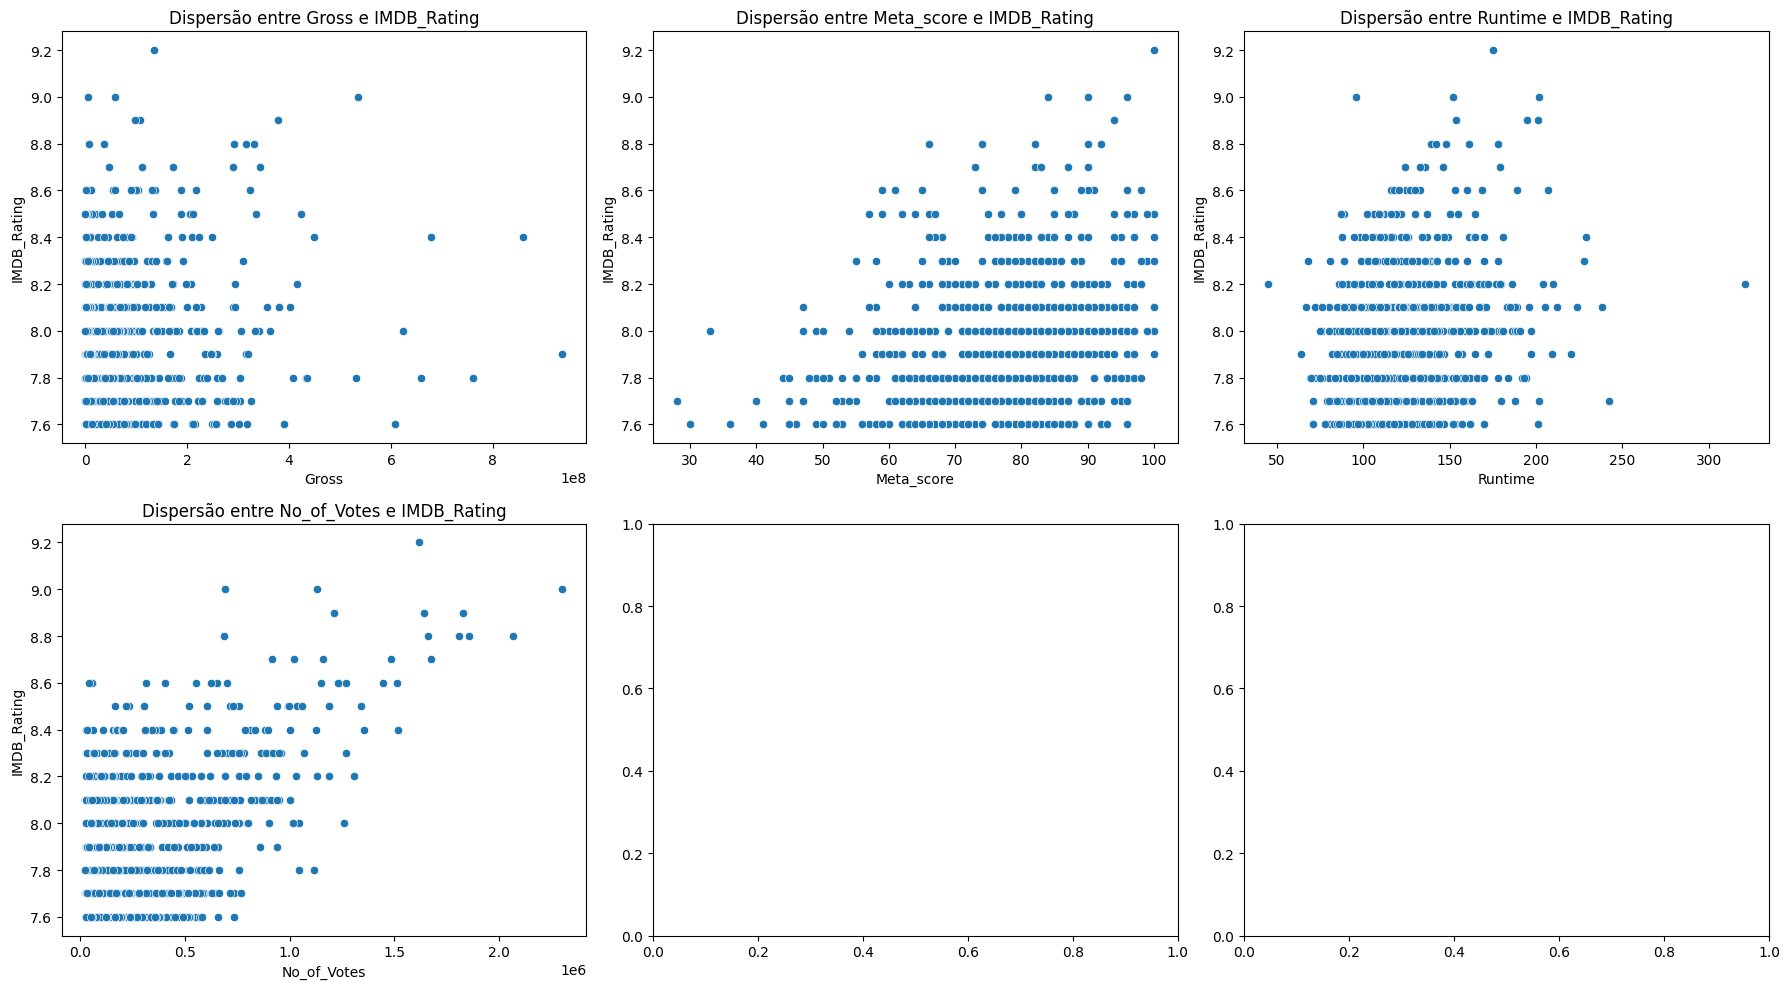

In [149]:
def plotar_Grafico_dispersao(display):

    # Lista de variaveis para plotar contra IMDB_Rating
    variaveis = ['Gross', 'Meta_score', 'Runtime', 'No_of_Votes']

    # Configuração da figura de plotagem
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10)) # 2 linhas, 3 colunas
    axes = axes.flatten()  # Achatar a matriz de eixos para facilitar a iteração

    # Plotar cada variavel contra IMDB_Rating
    for i, var in enumerate(variaveis):
        if var in display.columns and 'IMDB_Rating' in display.columns:
            sns.scatterplot(data=display, x=var, y='IMDB_Rating', ax=axes[i])
            axes[i].set_title(f'Dispersão entre {var} e IMDB_Rating')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('IMDB_Rating')
        else:
            print(f"Coluna {var} ou IMDB_Rating não encontrada no DataFrame.")
            axes[i].set_visible(False)  # Ocultar o eixo se a coluna não existir
        
    plt.tight_layout()  # Ajustar o layout para evitar sobreposição
    plt.show()

plotar_Grafico_dispersao(display)

>Dado os graficos acima podemos afirmar que:

**Gross vs IMDb_Rating**: Não existe uma forte correlação entre ganhos de bilheteria de um filme (Gross) e sua classificação no IMDb devido aos pontos estarem muito espalhados horizontalmente

**Meta-score vs IMDb_Rating**: Existe uma correlação positiva embora imperfeita, é possível observar em a medida que o Meta-score aumenta, o IMBd_Rating também tende a aumentar

**Runtime vs IMDb_Rating**: O grafico de dispersão entre Runtime e IMDb_rating mostra uma linha horizontal de pontos que estão fortemente concentrados, isso mostra que muitos filmes possuem Runtime semelhantes mas uma ampla gama de IMDb_Rating mostrando que a duração de um filme não é uma forma confiável de prever a sua classificação.

**No_of_Votes vs IMDb_Rating**: Esse gráfico mostra uma relação positiva, embora seja claro que filmes com bastante números de votos tendem a possuir uma nota mais alta no IMDb.

>  levantar hipóteses

# **Respostas da questão 2 do processo seletivo**

## **Alternativa A)** Qual filme você recomendaria para uma pessoa que você não conhece? 

Após analisar os graficos da EDA, notei que o numero de votos é fortemente relacionado à nota do IMDb, então eu claramente recomendaria o filme com o maior número de votos, pois sugere que é um filme popular e amplamente aclamado pela crítica. Segue o codigo na proxima célula para encontrar esse filme no DataFrame


In [150]:
def encontrar_maior_numero_votos(display):
     
    # o metodo idxmax() retorna o indice do maior valor na coluna 'No_of_Votes'
    filme_mais_votado = display.loc[display['No_of_Votes'].idxmax()]
    print("Filme com o maior número de votos:")
    print(filme_mais_votado[['Series_Title', 'No_of_Votes', 'IMDB_Rating']])
    

encontrar_maior_numero_votos(display)

Filme com o maior número de votos:
Series_Title    The Dark Knight
No_of_Votes             2303232
IMDB_Rating                 9.0
Name: 1, dtype: object




> *Após a analise dos dados o filme recomendado seria: The Dark Knight, 9.0 (IMDb)*


Porém eu gostaria de utilizar mais duas métricas para validar a recomendação, elas são.
-   O filme com a maior classificação (IMDb)

In [151]:
def encontrar_maior_IMDb_Rating(display):

    maior_imdb = display.loc[display['IMDB_Rating'].idxmax()]
    print("Filme com a maior classificação (IMDb):")
    print(maior_imdb[['Series_Title', 'IMDB_Rating', 'No_of_Votes']])
encontrar_maior_IMDb_Rating(display)

Filme com a maior classificação (IMDb):
Series_Title    The Godfather
IMDB_Rating               9.2
No_of_Votes           1620367
Name: 0, dtype: object



> *O filme com o maior nota no IMDB é: The Godfather, 9.2 (IMDB)*

- E uma a junção das duas métricas, o filme com o maior numero de votos e maior nota do IMDB em paralelo, codigo na proxima célula:

In [152]:
def maior_votos_e_nota(display):

    # Encontrar o maior número de votos
    max_votos = display['No_of_Votes'].max()

    # Filtrar os filmes que têm o maior número de votos
    filmes_com_mais_votos = display[display['No_of_Votes'] == max_votos]

    # Dentre esses filmes, encontrar aquele com a maior nota do IMDb
    filme_recomendado = filmes_com_mais_votos.loc[filmes_com_mais_votos['IMDB_Rating'].idxmax()]

    print("Filme com o maior número de votos e maior nota do IMDb:")
    print(filme_recomendado[['Series_Title', 'No_of_Votes', 'IMDB_Rating']])
maior_votos_e_nota(display)

Filme com o maior número de votos e maior nota do IMDb:
Series_Title    The Dark Knight
No_of_Votes             2303232
IMDB_Rating                 9.0
Name: 1, dtype: object


Por fim o filme mais recomendado seria justamente:
>### **resposta a) The Dark Knight, 9,0 (IMDB)**

----

## **Alternativa b)** Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

*Para o desenolvimento dessa questão eu irei precisar levantar alguns graficos contra o atributo (GROSS) e verificar se há alguma relação entre eles*:

- Primeiro vou utilizar alguns atributos que tem relação casual com o sucesso comercial de um filme, são elas: Runtime, Genre, IMDB_Rating, Meta_score, No_of_votes, essas serão as variaveis preditivas (x) e a variável alvo será o gross (y)
  
- Precisarei utilizar one-hot-encoding para transformar o atributo Genre em um valor número e assim poder treinar o modelo para mostrar o impacto dos fatores em ralação à expectativa do faturamento

Notei que o metodo pd.get_dummies esta tratando a combinação de gêneros como uma categoria unica, ex: 'Genre_Horror, Mystery, Sci-fi'. Então agora eu vou separar esses categorias, para que cada coluna tenha apenas um genero, isso vai deixar o modelo mais assertivo.

### **Separar Gêneros dos filmes**

In [153]:
def genre_encode(display):
    # Assegura que o índice não é duplicado após o explode
    display = display.reset_index()
    # Dividir as colunas genero
    display['Genre'] = display['Genre'].str.split(r',\s*')
    # Explodir a coluna para ter uma linha por genero
    display = display.explode('Genre')
    # Aplicar one-hot-encoding na coluna 'Genre'
    display_encoded = pd.get_dummies(display, columns=['Genre'], prefix='Genre')
    # Agrupar por filme
    display_final = display_encoded.groupby(display_encoded.index).sum()
    display_final = display_final.dropna()
    # print("Colunas após one-hot-encoding e agrupamento:")
    # print(display_final.columns)
    return display_final

### **Mapa de calor**

Com o encode feito eu irei criar um mapa de calor para visualizar a matriz da correlação entre as variaveis e o faturamento

Mapa de calor da correlação salvo como 'heatmap_correlacao_filmes.png'.


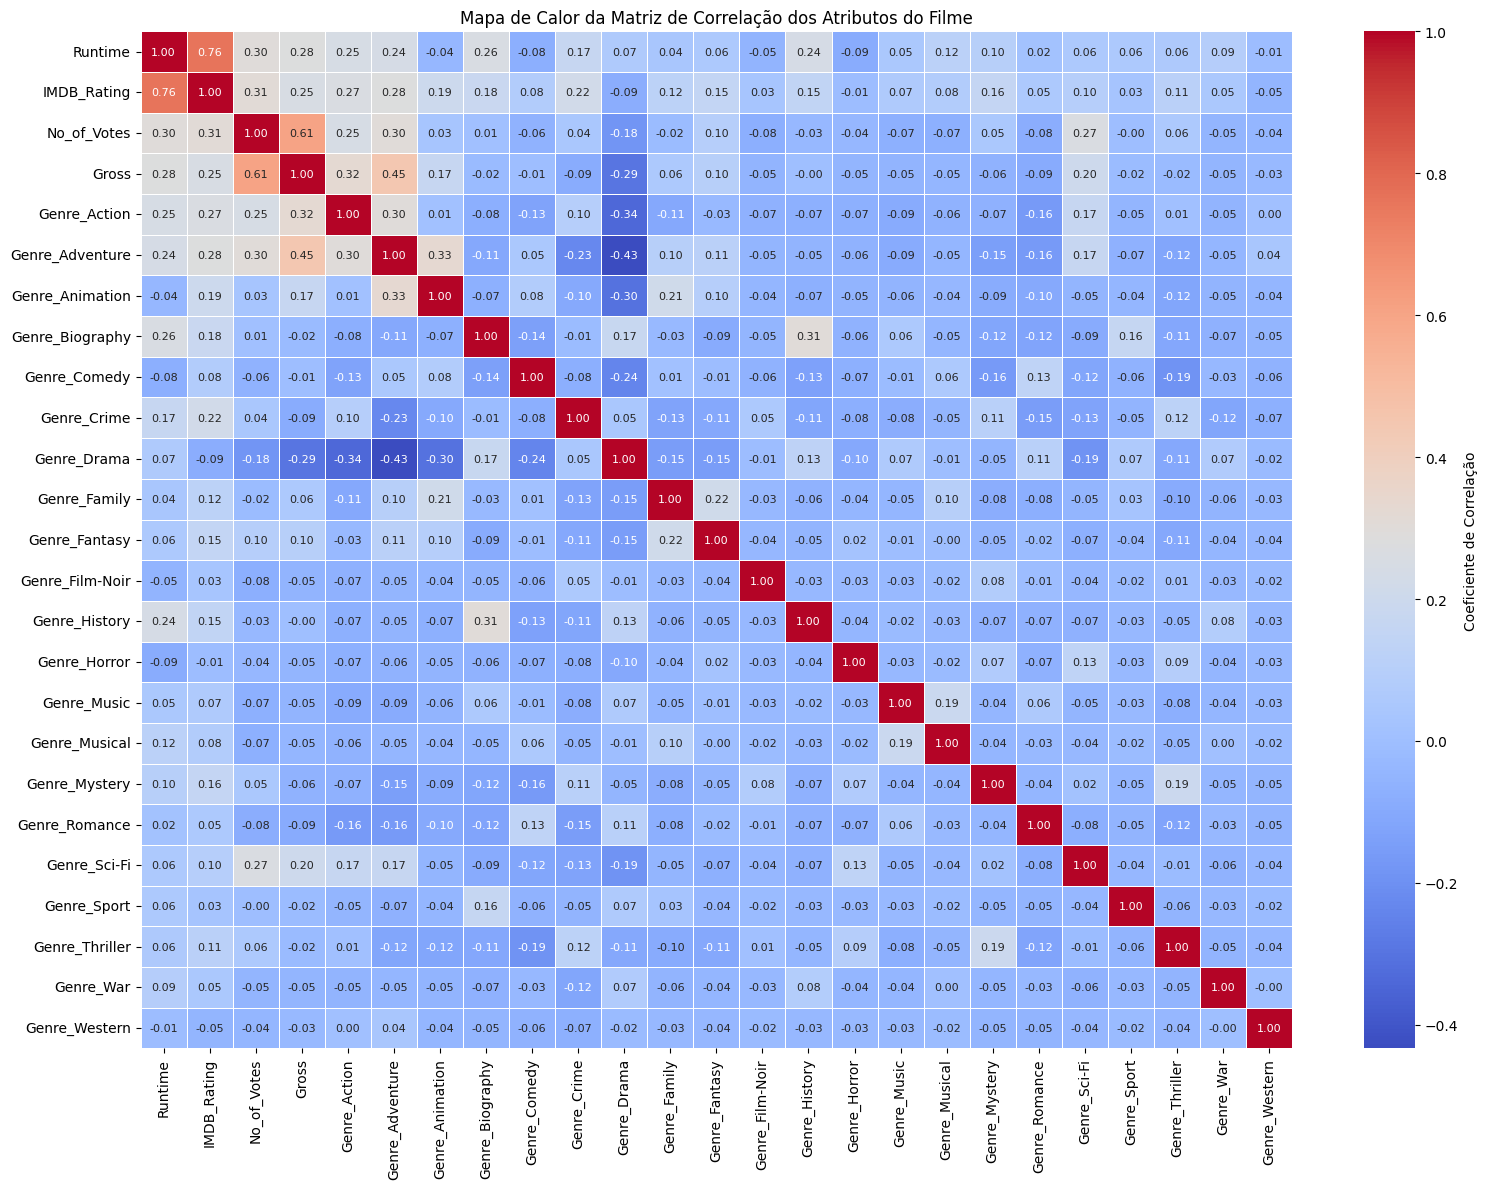

In [154]:
def mapa_de_calor_faturamento(display):
  
    # atribui o encode de genero a uma nova variavel
    display_final = genre_encode(display)
    genre_columns = [col for col in display_final.columns if col.startswith('Genre_')]
    columns_to_correlate = ['Runtime', 'IMDB_Rating','No_of_Votes', 'Gross'] + genre_columns
    df_corr = display_final[columns_to_correlate].copy()
    df_corr.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_corr.dropna(inplace=True)
    
    correlation_matrix = df_corr.corr()

   
    plt.figure(figsize=(16, 12))

    
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=.5,
        cbar_kws={'label': 'Coeficiente de Correlação'},
        annot_kws={"size": 8}
    )

    
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) 
    plt.title('Mapa de Calor da Matriz de Correlação dos Atributos do Filme')
    plt.tight_layout()
    plt.savefig('heatmap_correlacao_filmes.png')
    print("Mapa de calor da correlação salvo como 'heatmap_correlacao_filmes.png'.")

mapa_de_calor_faturamento(display)

Retirei o Meta_score da equação pois identifiquei uma forte correlação com o IMDB, isso é um problema pois essas variaveis estão medindo a mesma coisa, o que pode levar a coeficientes instáveis em modelos de regressão.

> Cores mais quentes: Correlação positiva

> Cores mais frias: Correlação negativa

### **Criação do modelo de expectativa de faturamento**

In [155]:

def modelo_expectativa_faturamento(display):
    try:
        display = pd.read_csv('../data/desafio_indicium_imdb.csv')
    except FileNotFoundError:
        print("Erro: O arquivo 'desafio_indicium_imdb.csv' não foi encontrado.")
        return
    
     # chamo a função de normalização dos dados
    display = normalizar(display)
    
    # atribui o encode de genero a uma nova variavel
    display_final = genre_encode(display)

    # Definir as variveis preditoras (X) e a variável alvo (y)

    genre_columns = [col for col in display_final.columns if col.startswith('Genre_')]
    X = display_final[['Runtime', 'IMDB_Rating', 'No_of_Votes'] + genre_columns]
    y = display_final['Gross']

    # Separar os dados em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Escalonar os dados
    scaler = StandardScaler()
    variaveis_numericas = ['Runtime', 'IMDB_Rating', 'No_of_Votes']
    X_train[variaveis_numericas] = scaler.fit_transform(X_train[variaveis_numericas])
    X_test[variaveis_numericas] = scaler.transform(X_test[variaveis_numericas])
    # Treinar e analisar o modelo de regressão linear
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)


    # Avaliando o modelo
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)


    print(f"R²: {r2:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    # Exibir coefficients
    coeficientes = pd.DataFrame(modelo.coef_, index=X.columns, columns=['Coeficiente'])
    print("Coeficientes do modelo de regressão linear:")
    print(coeficientes)


modelo_expectativa_faturamento(display)

R²: 0.50
RMSE: 207802480.16
MAE: 124382704.72
Coeficientes do modelo de regressão linear:
                  Coeficiente
Runtime          5.642764e+07
IMDB_Rating     -4.125805e+08
No_of_Votes      1.722189e+08
Genre_Action     6.328496e+08
Genre_Adventure  6.642694e+08
Genre_Animation  6.514613e+08
Genre_Biography  5.344178e+08
Genre_Comedy     5.653780e+08
Genre_Crime      4.902046e+08
Genre_Drama      5.179559e+08
Genre_Family     5.904314e+08
Genre_Fantasy    5.344916e+08
Genre_Film-Noir  6.509516e+08
Genre_History    5.790684e+08
Genre_Horror     5.704605e+08
Genre_Music      5.615109e+08
Genre_Musical    5.035973e+08
Genre_Mystery    5.018340e+08
Genre_Romance    5.497076e+08
Genre_Sci-Fi     5.198020e+08
Genre_Sport      5.502353e+08
Genre_Thriller   5.362745e+08
Genre_War        5.345114e+08
Genre_Western    5.213092e+08


O modelo nos retornou os coeficientes que representam o quanto a variavel dependente (faturamento do filme) muda para cada aumento de unidade em uma variavel independente.
- Positivo: Um aumento no fator está associado a um aumento no faturamento
- Negativo: Um aumento no fato esta associado a uma diminuição no faturamento

A magnitude do valor indica a força da relação. Quanto maior o valor, mais significativo é o impacto.

### **Resposta b)** Com base no modelo de regressão, o genero do filme é o indicador mais relacionado com o indice de faturamento, dentre eles estão: Filme-Noir, Ação e Aventura



## *Alternativa c) Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?*

>    *Insights*

- Quais palavras mais frequentes? ex: "Técnologia", "Drama", "Vingança".

- É possível analisar o tom das sinópses? Filmes de ficção científica utilizam palavras mais acadêmicas?

### **Listar palavras mais frequentes utilizando geração ode linguagem natural:**


In [156]:
def limpar_texto(texto):
    # Remover caracteres especiais e números e converte para minusculo
    texto = re.sub(r'[^a-zA-Z\s]', '', texto.lower())
    # Tokenizar o texto
    tokens = word_tokenize(texto, language='english')
    # Remover stopwords
    stop_words = set(stopwords.words('english'))
    tokens_limpos = [word for word in tokens if word not in stop_words]
    # Juntar os tokens de volta em uma string
    texto_limpo = ' '.join(tokens_limpos)
    return texto_limpo


display['final_overview'] = display['Overview'].apply(limpar_texto)

print(display[['Genre', 'final_overview']].head())


                      Genre                                     final_overview
0              Crime, Drama  organized crime dynastys aging patriarch trans...
1      Action, Crime, Drama  menace known joker wreaks havoc chaos people g...
2              Crime, Drama  early life career vito corleone new york city ...
3              Crime, Drama  jury holdout attempts prevent miscarriage just...
4  Action, Adventure, Drama  gandalf aragorn lead world men saurons army dr...


Com as sinópses organizadas podemos partir para o proximo passo que será extrair as caracteristicas necessarias para o modelo caracterizar o genero. Para isso vou utilizar o método TF-IDF, ele converte o texto em uma matriz numérica, onde cada palavra vai ter um peso que reflete a sua importância, e não apenas uma contagem

TF-IDF (Termo de frenquencia - Termo de frequencia inverso)

  - Termo de frequencia: A frequencia onde cada palavra aparece em uma sinópse
  - Termo de frequência inverso: A raridade de uma palavra no conjunto das sinopses. Por exemplo, palavras como filme ou historio têm um valor baixo, enquanto palavras que são únicas ou pouco frequentes tem um valor alto

### **Extração das características**

In [ ]:
def vetorizar_texto(dipslay):

    # criando uma instancia do TfidfVectorizer e limitando as 30 palavras mais importantes
    vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,3))


    # Aplicando a vetorização para transformar o texto em uma matriz numérica
    # E convertendo para um arrai
    x = vectorizer.fit_transform(display['final_overview']).toarray()
    nomes_palavras = vectorizer.get_feature_names_out()
    print("Palavras mais importantes (features):")
    #print(nomes_palavras)

    return x, nomes_palavras, vectorizer




Com as características extraídas, iremos dividir os dados em conjuntos de treinamento e teste para o modelo aprender com os dados e testar para garantir que ele possa fazer previsões de sinópses que nunca viu.

In [158]:

def treinar_modelo(X, y):

   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Classificador base
    model_base = LinearSVC(class_weight="balanced")
    model = OneVsRestClassifier(model_base) # Treina um modelo para cada genero separadamente
    
    # Treinamnto
    model.fit(X_train, y_train)
    print("\nModelo treinado com sucesso.")

    # Avaliação
    y_pred = model.predict(X_test)
    print("F1-score (micro):", f1_score(y_test, y_pred, average="micro"))
    print("F1-score (macro):", f1_score(y_test, y_pred, average="macro"))
    print("Hamming Loss:", hamming_loss(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return model

# Função para testar o modelo
def prever_genero(novas_overwiew, model, vectorizer, mlb):
    # Vetorizar as novas sinopses utilizando o mesmo vetorizador de treino
    novas_tfidf = vectorizer.transform(novas_overwiew)
    
    # Previsão
    y_pred = model.predict(novas_tfidf)
    
    # separar os generos previsto
    generos_previstos = mlb.inverse_transform(y_pred)
    
    # Mostrar resultados
    for i, sinopse in enumerate(novas_overwiew):
        print(f"\nSinopse: {sinopse}")
        print(f"Gêneros previstos: {generos_previstos[i]}")
        
    return generos_previstos
    
# Chamo a função para vetorizar o texto e obter o X
X, nomes_palavras, vectorizer = vetorizar_texto(display)

# Chamando a função para codificar os generos e obter o y
y_display = genre_encode(display)
y_display = y_display[[col for col in y_display.columns if col.startswith("Genre_")]]

# Garanto que os valores de y são númericos
y_display.index = y_display.index.astype(int)

X = X[y_display.index]  # Garantir que X e y tenham o mesmo índice
y = y_display.values # Convertendo y para um array para ter compatibilidade com X  

# Classificação de genero multilabel (separar generos por filme)
mlb = MultiLabelBinarizer(classes=y_display.columns)
mlb.fit(y_display.values)

# treinar modelo
model = treinar_modelo(X, y)

# Salvar modelos

joblib.dump(model, "modelo_generos.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(mlb, "mlb.pkl")

# Passo a sinopse de um novo filme para testar a previsão
novos_filmes = [
    "A young boy discovers he has magical powers and attends a school of wizardry where he faces dark forces.",
    "A retired soldier must fight to save his family from alien invaders."
]
prever_genero(novos_filmes, model, vectorizer, mlb)


Palavras mais importantes (features):

Modelo treinado com sucesso.
F1-score (micro): 0.5294117647058824
F1-score (macro): 0.2689092718261603
Hamming Loss: 0.09142857142857143
              precision    recall  f1-score   support

           0       0.47      0.26      0.34        34
           1       0.67      0.25      0.36        40
           2       0.75      0.17      0.27        18
           3       0.75      0.24      0.36        25
           4       0.47      0.33      0.38        46
           5       0.50      0.28      0.36        43
           6       0.85      0.90      0.87       157
           7       1.00      0.20      0.33         5
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         8
          11       1.00      0.20      0.33        10
          12       0.33      0.11      0.17         9
          13       0.00      0.00      0.00         4
          14 

c:\Users\leomi\Desktop\Repositorio GIT\Modelo-Preditivo-IMDB\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\leomi\Desktop\Repositorio GIT\Modelo-Preditivo-IMDB\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[('Genre_Adventure', 'Genre_Family', 'Genre_Fantasy'),
 ('Genre_Action', 'Genre_Sci-Fi')]

Objetivo do Modelo: prever generos dos filmes com base na descrição (overview) utilizando o aprendizado multilabel devido a 1 filme poder ter mais de 1 genero.

Utilizei a coluna final_overview para extrair as informações textuais.
Os generos foram codificado em binario utilizando One-Hot Encoding através da função genre_encode()

Optei por utilizar TF-IDF para transformar os textos em numericos e dar peso à ele:
- **max_features: 3000** -> limitei a 3000 palavras mais relevantes, achei um bom numero para um processamento rápido e uma gama de palavras relevantes para o treino
- **stop_words='english'** -> removi palavras irrelevantes
- **ngram_range= (1,2)** -> considera palavras isoladas e pares de palavras para captura um melhor contexto

Essas escolhas foram tomadas após diversos testes, após verificar que o modelo gerava matrizes muito esparsas e piorava a performance

#### **Escolha do Modelo**

Foram testados diferentes modelos para a classificação multilabel:
- **Logistic Regression** -> rápido, mas com baixa perfomance 
  
- **Random Forest** -> bom desempenho, porém muito lento para um alto número de gêneros
  
- **LinearSVC** -> obteve o melhor equilíbrio entre performance e tempo e também corrige o desbalanceamento entre gêneros, evitando o favorecimento dos mais frequentes
  - OneVsRestClassifier: treina um modelo para cada genero seperadamento, ideal para o multilabel
  - class_weigth="balanced": Corrige o desbalanceamento entre generos frequentes e mais frequentes

> **Resultados obtidos:**
>
> 
  > **F1-Score (micro): ~0.52**, avalia o desempenho geral considerando todos os gêneros igualmente
>
  >
  > **F1-Score (macro): ~0.26**, avalia o desempenho médio por gênero, mais baixo devido alguns gêneros aparecerem mais do que outros
>
>
  > **Hamming Loss: ~0.09**, valor baixo indica que o modelo comete poucos erros por rótulo


Conclusão: *Apesar do bom resultado no geral, podemos testar se é possivel melhorar o macro-f1 utilizando tecnicas de redução do desbalanceamento e modelos mais avançados como XGBoost ou BERT.* 